In [439]:
import gymnasium as gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [493]:
class UAV_Environment(gym.Env):

    def __init__(self, users = 250, uavs = 3, size = 2000, 
                v_0 = 5, # (m/s)
                ###################### Channel model of UAVS
                psi_L = 1,
                psi_M = 1,
                K = 50, 
                d = 1, # (m)
                lambda_c = 0.1, # (m)
                h = 120, # (m)
                alpha = 2.7,
                P_UAV = 30, # (dBm)
                sigma_square = 90,  
                ###################### Channel model of mBS
                P_mBS = 46, # (dBm)
                D_hb = 10, # (m)
                f_c = 2e3, # GHz -> (MHz)
                sigma_logF = 2,
                ###################### Bandwidth
                W = 20e6, # MHz -> (Hz)
                ###################### Data Rate Threshold
                r_th = 20e6,
                ): 


        self.users = users
        self.uavs = uavs
        self.size = size
        self.v_o = v_0
        self.psi_L = psi_L
        self.psi_M = psi_M
        self.K = K
        self.d = d
        self.lambda_c = lambda_c
        self.h = h
        self.alpha = alpha
        self.P_UAV = P_UAV
        self.sigma_square = sigma_square
        self.P_mBS = P_mBS
        self.D_hb = D_hb
        self.f_c = f_c
        self.sigma_logF = sigma_logF
        self.W = W
        self.r_th = r_th

        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        self.users_location = np.random.uniform(-self.size/2, self.size/2, (2, self.users))
        self.mBS = np.zeros((2,1)) + self.size/2
        
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        # self.observation_space = gym.spaces.Dict(
        #     {
        #         "agent": gym.spaces.Box(-size/2, size/2, shape=(2,uavs), dtype=float),
        #     }
        # )

        self.observation_space = gym.spaces.Box(-self.size/2, self.size/2, shape=(2,uavs), dtype=float),


        # We have 5 actions, corresponding to "right", "up", "left", "down", "remain stationary"
        self.action_space = gym.spaces.Discrete(5)
        # Dictionary maps the abstract actions to the directions
        self._action_to_direction = {
            0: np.array([v_0, 0]),  # right
            1: np.array([0, v_0]),  # up
            2: np.array([-v_0, 0]),  # left
            3: np.array([0, -v_0]),  # down
            4: np.array([0, 0]),  # remain stationary
        }
    def step(self, actions):
        
        ## UAVs take the actions
        for action,k in zip(actions,range(self.uavs)):
            tem = self.uavs_location[:,k] + self._action_to_direction[action]
            if (-self.size/2 > tem[0] or tem[0] > self.size/2) or (-self.size/2 > tem[1] or tem[1] > self.size/2): # restrict the UAVs' coordinates
                continue
            self.uavs_location[:,k] = tem

        ## Distance
        d_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                d_UAV[k,n] = np.linalg.norm(self.users_location[:,n] - self.uavs_location[:,k], ord = 2)

        d_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            d_mBS[0,n] = np.linalg.norm(self.users_location[:,n] - self.mBS[:,0], ord = 2)

        ## Signal-to-noise ratio(SNR)
        gamma_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                psi_UAV = math.sqrt(self.K/(1+self.K))*self.psi_L + math.sqrt(1/(1+self.K))*self.psi_M
                theta = -20*math.log10(4*3.14*self.d/self.lambda_c)
                g_UAV = (abs(psi_UAV)**2)*theta*(math.sqrt(d_UAV[k,n]**2 + self.h**2)/self.d)**(-self.alpha)
                gamma_UAV[k,n] = self.P_UAV*g_UAV/self.sigma_square

        gamma_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            LogF = random.gauss(0, self.sigma_logF)
            L_mBS = 40*(1-0.004*self.D_hb)*math.log10(d_mBS[0,n]/1000) - 18*math.log10(self.D_hb) + 21*math.log10(self.f_c) # + 80 # d_mBS (km) ; D_hb (m); fc (MHz)
            gamma_mBS[0,n] = self.P_mBS - L_mBS - LogF

        ## Data rate
        rate_UAV = np.zeros((self.uavs,self.users))
        for n in range(self.users):
            for k in range(self.uavs):
                gamma_UAV[k,n] = 10**(gamma_UAV[k,n]/10)
                rate_UAV[k,n] = self.W*math.log2(1 + gamma_UAV[k,n])
                    
        rate_mBS = np.zeros((1,self.users))
        for n in range(self.users):
            gamma_mBS[0,n] = 10**(gamma_mBS[0,n]/10)
            rate_mBS[0,n] = self.W*math.log2(1 + gamma_mBS[0,n])
            

        ##### connect =
        #####    [ ------------ UAV1 -----------] 
        #####    [ ------------ UAV2 -----------]
        #####    [ ------------ UAV3 -----------]
        #####    [ ------------ mBS  -----------]
        connect = np.zeros((self.uavs+1, self.users))
        
        # print('UAV data rate: ', rate_UAV,'\n mBS data rate: ' ,rate_mBS)
        rate_UAV_mBS = np.concatenate((rate_UAV, rate_mBS), axis=0) # Shape(4,150) -> 3 UAVs + 1 mBS ; 150 Users
        data_rate_max_index = np.argmax(rate_UAV_mBS, axis=0)
        for index,user in zip(data_rate_max_index,range(self.users)):
            connect[index,user] = 1

        data_rate = np.multiply(rate_UAV_mBS,connect)
        data_rate = np.sum(data_rate,axis=0)

        # S_t
        S = 0
        for r_n in data_rate.tolist():
            if r_n > self.r_th:
                S = S + 1
        print('S=', S)

        N_UAVs = np.sum(connect,axis=1)
        N_UAV1 = N_UAVs[0]
        print('N_UAV1=',N_UAV1)
        N_UAV2 = N_UAVs[1]
        print('N_UAV2=',N_UAV2)
        N_UAV3 = N_UAVs[2]
        print('N_UAV3=',N_UAV3)
        
        return self.uavs_location, S, N_UAV1, N_UAV2, N_UAV3

    def plot(self):
        plt.scatter(self.users_location[0,:],self.users_location[1,:], label = 'USER')
        plt.scatter(self.uavs_location[0,:],self.uavs_location[1,:], label = 'UAV')
        plt.scatter(self.mBS[0],self.mBS[1], label = 'mBS')
        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.title('UAV Environment')
        plt.legend()
        plt.show()

    def reset(self):
        self.uavs_location = np.zeros((2, self.uavs)) + self.size/2
        return self.uavs_location       
            

In [494]:
env = UAV_Environment()

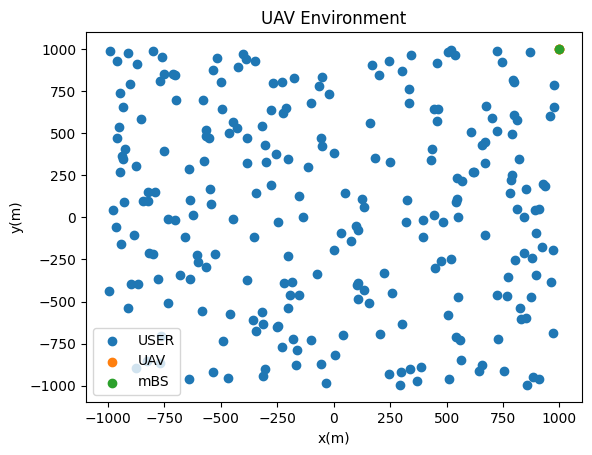

In [495]:
env.plot()

In [496]:
state = env.reset()
for _ in range(100):
    actions = []
    for i in range(4):
        actions.append(env.action_space.sample())
    state, reward = env.step(actions)


S= 26
N_UAV1= 0.0
N_UAV2= 224.0
N_UAV3= 0.0


ValueError: too many values to unpack (expected 2)

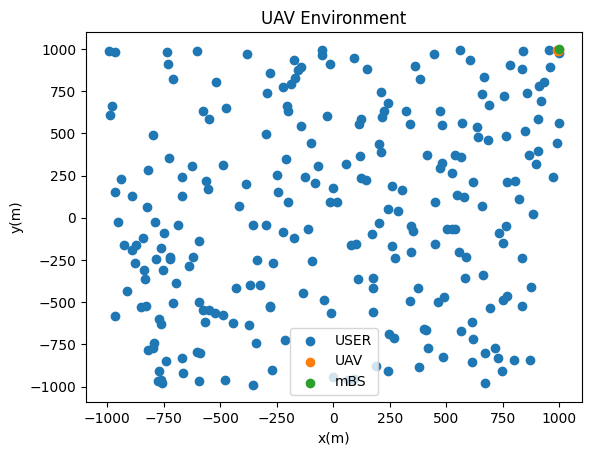

In [419]:
env.plot()

In [420]:
state

array([[ 990., 1000.,  995.],
       [ 995.,  995.,  985.]])